## 💻 UnpackAI DL201 Bootcamp - Week 2 - Skills: Preprocessing Image Data

### 📕 Learning Objectives

* Have an appreciation for the diversity of image preprocessing tasks in various situations and that no one size fits all solution exists
* Gain an understanding of **spacial filtering**, the principles of how it works from a code based perspective, and how to apply to remove noise, sharpen edges, and detect edges
* Grasp the concept of thresholding, and appreciate how it can be a powerful tool
* Understand the difference between local and global thresholding, and the challenges involved. 

### 📖 Concepts map

* Spacial Filtering
* Thresholding
* Image Masking
* Global vs Local




In [2]:
# import (use not verbose mode : ex "import -Uqq pandas as pd" if you are sure that there is no dependency error)
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
from pathlib import Path
from PIL import Image
import IPython.display
import wand.image  # requires Imagemagick and !pip install Wand

In [155]:
# import data and images if necessary, and choose the right path
is_kaggle = False   # True if you are on Kaggle, False for local Windows, Linux or Mac environments.

if is_kaggle:
    !git clone https://github.com/unpackAI/DL201.git
    IMAGE_DIR = Path('/kaggle/working/DL201/img')
    DATA_DIR = Path('/kaggle/working/DL201/data')
else:
    # This section is for local execution, it is assumed that the notebook is on the 'Week-2' folder
    # of the DL201 repository.
    DATA_DIR = Path('../data')
    IMAGE_DIR = Path('../img')

# finally, check if we found the right pathes
if os.path.isdir(DATA_DIR):
    print(f'DATA_DIR is a directory, its path is {DATA_DIR}')
else:
    print("ERROR : DATA_DIR is not a directory")

if os.path.isdir(IMAGE_DIR):
    print(f'IMAGE_DIR is a directory, its path is {IMAGE_DIR}')
else:
    print("ERROR : IMAGE_DIR is not a directory")
    
# picture display function
def PictureDisplayJPG(picture_name):
    image_file_path = str(IMAGE_DIR/'week2'/picture_name)
    img = cv2.imread(image_file_path)
    img_array = np.array(img)
    plt.imshow(img_array)
    plt.show()
    
def PictureDisplayPNG(picture_name):
    image_file_path = str(IMAGE_DIR/'week2'/picture_name)
    img = cv2.cvtColor(cv2.imread(image_file_path), cv2.COLOR_BGR2RGB)
    img_array = np.array(img)
    plt.imshow(img_array)
    plt.show()
    
# make the picture bigger
plt.rcParams['figure.figsize'] = [7, 7]

DATA_DIR is a directory, its path is ..\data
IMAGE_DIR is a directory, its path is ..\img


# Part 1. Introduction

## 1.1 Why do we need pre-processing

There are several grades of image pre-processing. Some will only slightly improve the quality of the images (ex : noise reduction) so that the AI model will work better, while others will bring consistent modifications on the original images (ex : background suppression), enlighting shapes or features much more easy to work with than conventional images.

In some situations, data may not need preprocessing if the model is trained on really various images (ex : uploaded by different users, using different cameras, taking pictures in a variety of lighting conditions, etc) while others, such in an industrial setting, may require fine tuned preprocessing steps to increase the performance of their model (ex : highlight defective products that have to be removed from a production line). 

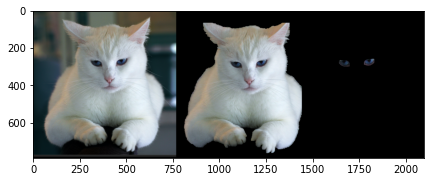

In [156]:
 PictureDisplayPNG("cat_without_background.png")

## 1.2 Do I need to know advanced mathemathics to preprocess images? 

While there's always some level of math involved in the pre-processing algorithms, python make them easy to call as pre-defined functions. So, most of the time, you just need to know the name of the algorithm and do not need to implement it by your self. In those cases, no math is required.

Likewise, you don't need to impliment a Fourier transform from scratch, as long as you can understand the inputs and outputs of it, and what they mean towards accomplishing the objective of cleaning and enhancing the data.

Before deep learning, one of the most common ways to extract features was SIFT and its evolutions like SURF. SIFT was very complex algorithms that few people understood completely, but it is heavily cited because everyone used it.

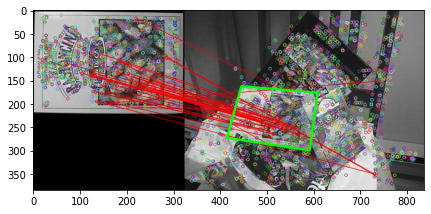

In [157]:
PictureDisplayJPG("SURF_Homography.jpg")

Now, most deep-learning methods and their pre-processing steps are mostly based on simple matrix operations, such as convolutional products. Let's notice that this convolutional product is the same as the one used on the convolutional neural networks, which are the base of the most famous pictures classification AI models.

The following picture was extracted from this website : https://scientistcafe.com/ids/convolutional-neural-network.html

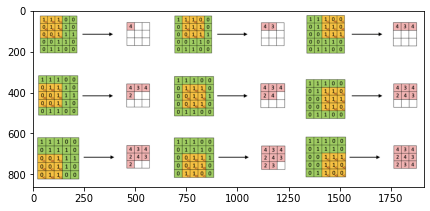

In [158]:
PictureDisplayPNG("convolutionsbs.png")

## 1.3 The main methods of image pre-processing

There are many groups of image-preprocessing. Common ones are :

* Color transforms
* Filtering
    - Spacial filters
    - Frequency filters
* Thresholding
    
In this notebook, we'll briefly present color transforms, before giving more details on ***Thresholding*** and ***Spacial Filters*** because they are related to the concepts learned in the first week and build on top of them.

# Part 2. Color Transforms

Color transforms consist in changing the dimension of an image to make it easier to work with, by human being or by an AI model.

The two most common examples is the transform between RGB (red green blue) and grayscale images.
$$ RGB --> grayscale $$

But if you work with images made for printers, then you may have to work with CMYK (cyan, magenta, yellow, black) images, that you would have to convert into RGB ones.
$$ CMYK --> RGB $$

Finally, if you use a pretrained model that was trained on color images, you should consider transforming your grayscale images into color images.
$$ grayscale --> RGB $$

It may make sense to preprocess X-rays and MRIs using this technique, because X-rays and MRIs are often black and white or monochrome. By expanding the color spectrum to include more color, it can highlight features that would be more difficult to spot otherwise.

In [159]:
braintumor = Image.open(IMAGE_DIR/'week2/braintumor.jpg')

In [160]:
grayscale = np.array(braintumor)

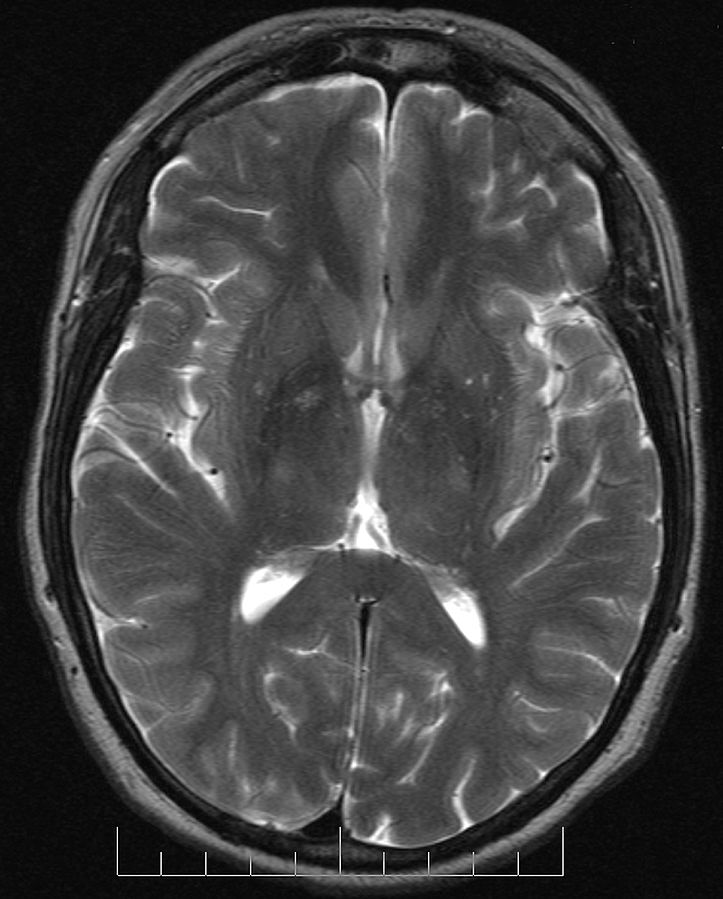

In [161]:
IPython.display.Image(IMAGE_DIR/'week2/braintumor.jpg',
                      width=250,height=250)

In [162]:
pseudoColoredImage = cv2.applyColorMap(grayscale, cv2.COLORMAP_JET)

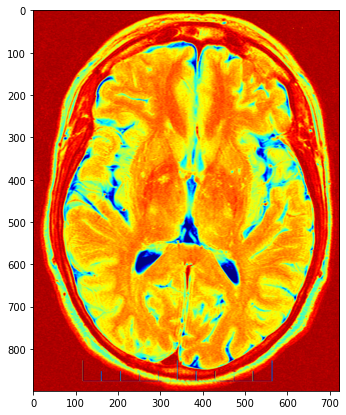

In [163]:
plt.imshow(pseudoColoredImage)
plt.show()

In [164]:
print(f'shape of the grayscale image : {grayscale.shape}')
print(f'shape of the pseudo color image : {pseudoColoredImage.shape}')

shape of the grayscale image : (899, 723)
shape of the pseudo color image : (899, 723, 3)


# Part 3. Spatial Filters

## 3.1 Definition
A Spacial Filter uses the principle of using the information in neighboring pixels to be able to correct, restore, or enhance the image. 

## 3.2 How they work
This is done using a mask, which is a small 3x3 or larger matrix that is moved across all of the pixels. Here is an example where we will add some noise to an image.

In [165]:
example_img_path = str(IMAGE_DIR/'week2/chimpanzee.jpg')
noisy_img_path = str(IMAGE_DIR/'week2'/"noisyExample.jpg")
noisy_img_path2 = str(IMAGE_DIR/'week2'/"noisyExample2.jpg")

example_img = cv2.imread(example_img_path)
# Read image using Image() function
with wand.image.Image(filename=example_img_path)as noisy_img:  
    noisy_img.noise("gaussian", attenuate = 2)
    noisy_img.save(filename = noisy_img_path)
    
noisy_img1 = cv2.imread(noisy_img_path)
    
with wand.image.Image(filename=example_img_path)as noisy_img:  
    noisy_img.noise("poisson", 0.5, "green")
    noisy_img.save(filename = noisy_img_path2)
    
noisy_img2 = cv2.imread(noisy_img_path2)

In [171]:
image_width = 250
image_height = 250
# use 1000 1000 to get bigger pictures

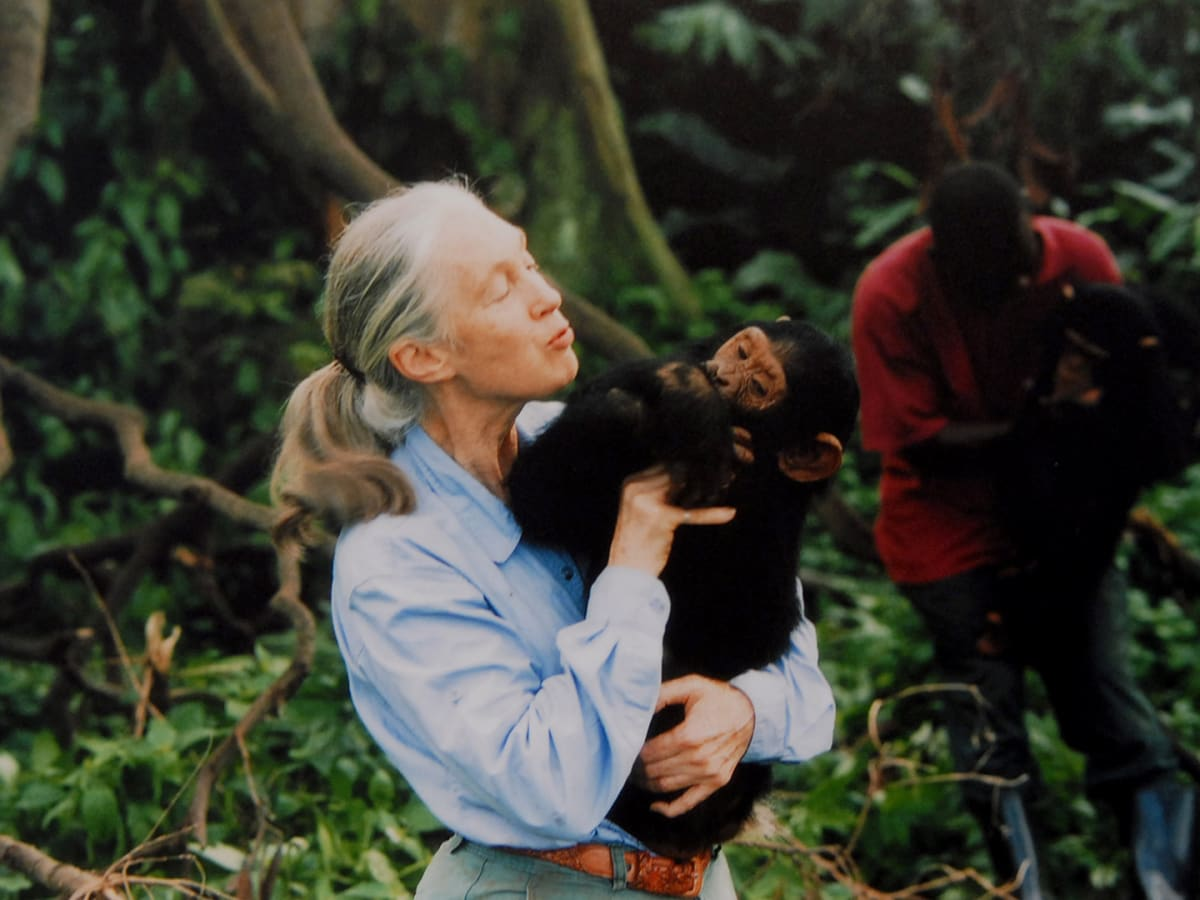

In [172]:
IPython.display.Image(example_img_path, width=image_width, height=image_height)

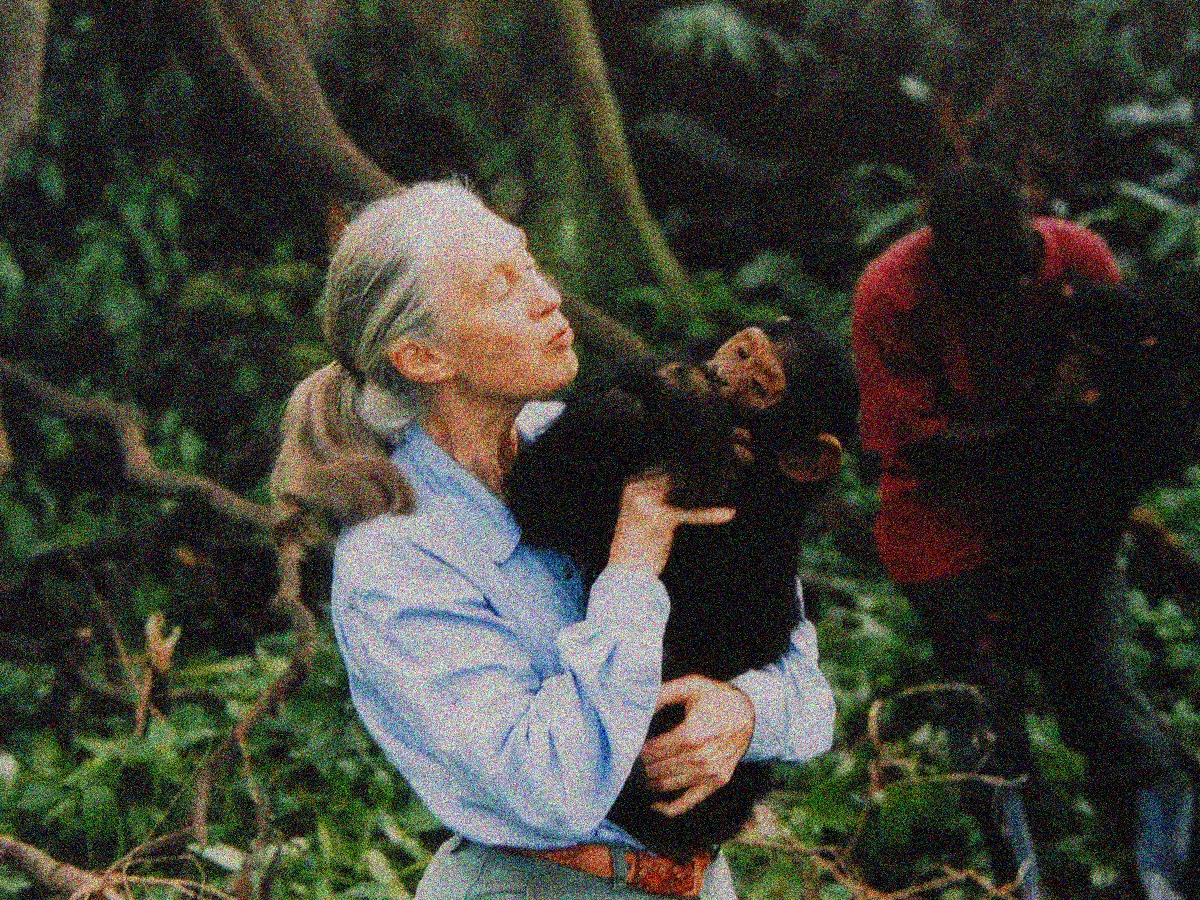

In [173]:
IPython.display.Image(noisy_img_path, width=image_width, height=image_height)

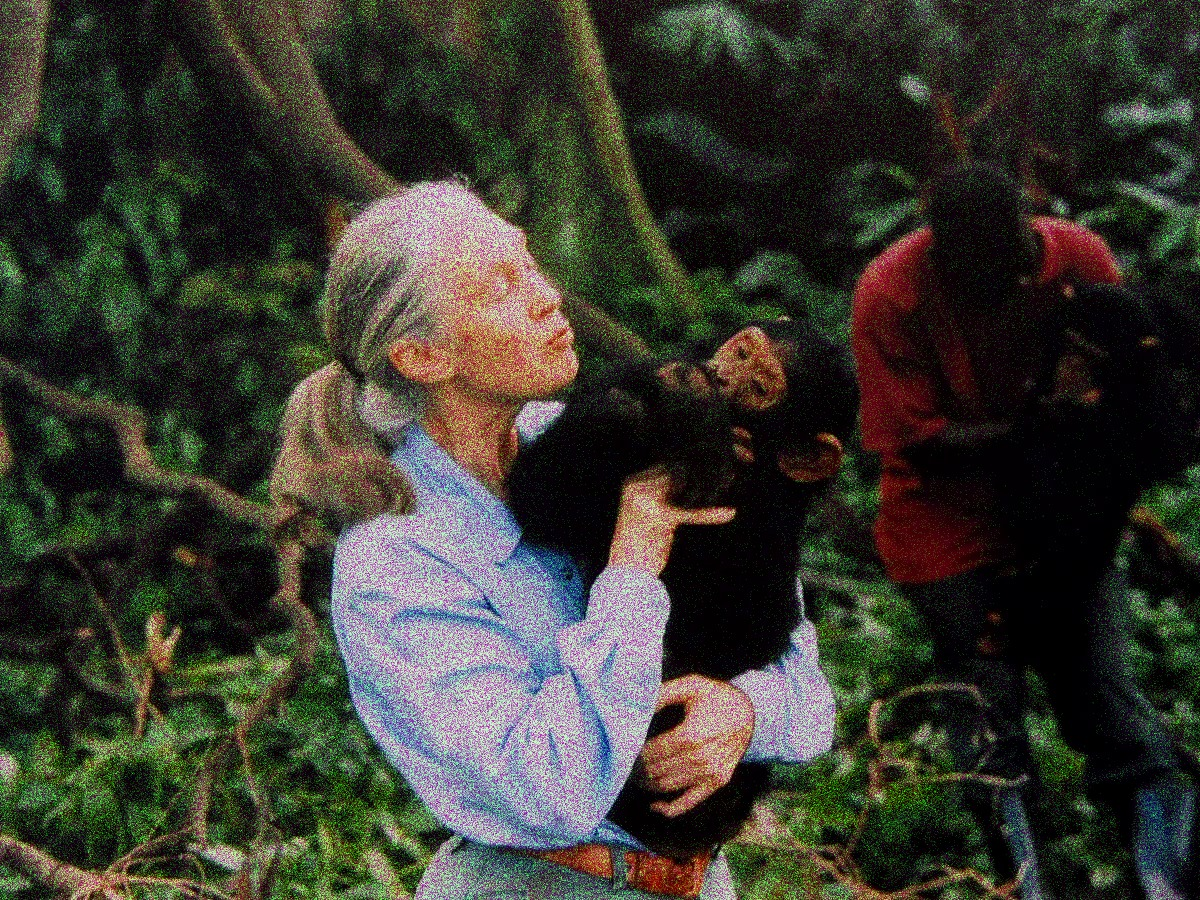

In [174]:
IPython.display.Image(noisy_img_path2, width=image_width, height=image_height)

## 3.3 Example of space filter : Noise Removal (Blurring)

A mean filter takes the values of all the pixels surrounding it, and applying it to that pixel. It does this across the entire image.

In [175]:
means_filtered_img = cv2.fastNlMeansDenoisingColored(noisy_img1,None,10,10,7,21)
gaussian_blurred_img = cv2.GaussianBlur(noisy_img1, (5, 5), 0)

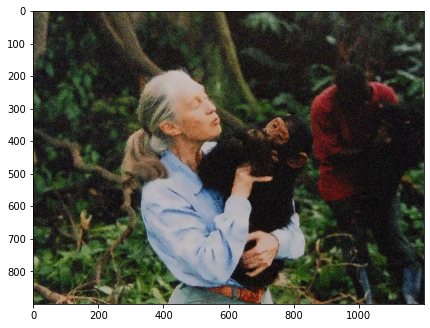

In [176]:
plt.imshow(cv2.cvtColor(means_filtered_img, cv2.COLOR_BGR2RGB))
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

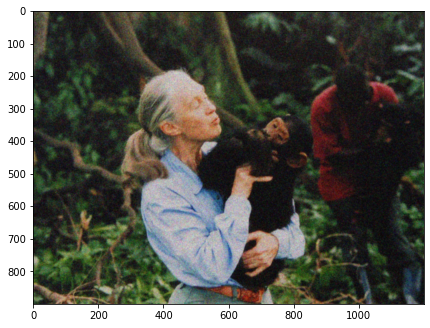

In [177]:
plt.imshow(cv2.cvtColor(gaussian_blurred_img, cv2.COLOR_BGR2RGB))
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

***Homeworks*** : search for the signification of the parameters of fastNlMeansDenoisingColored, try to modify them to get the better results on noisy_img1, and then, apply the same noise removal process on noisy_img2.

## 3.4 Example of space filter : Image Enhancement

After image correction, Spacial Filters can be used to ***sharpen images***.

In [178]:
kernel = np.array([[0,-2,0],
                   [-2,9,-2],
                   [0,-2,0]])

The 9 in the middle of this kernel will enlight the edges and borders, while the zero and negative values will let the "flat" areas unchanged.

In [179]:
grayscale_example = cv2.cvtColor(example_img, cv2.COLOR_RGB2GRAY)
img_sharp = cv2.filter2D(grayscale_example,-1, kernel)

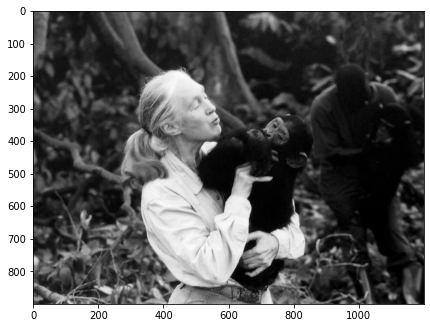

In [180]:
plt.imshow(grayscale_example, cmap='gray')
plt.show()

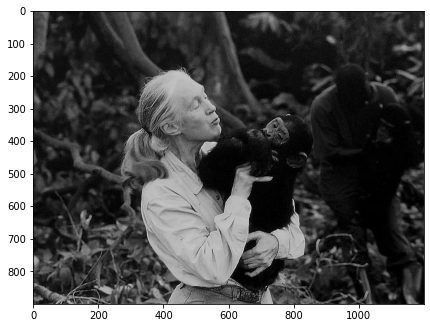

In [181]:
plt.imshow(img_sharp, cmap='gray')
plt.show()

## 3.5 Edge detection

As you may have learnt or will learn about convolutional neural networks, spacial kernels can be used to "detect" different shapes in the image.
Below, you can see that it is possible to find the horizontal and vertical 'edges' of an image.

In [182]:
image_file_path = str(IMAGE_DIR/'week2'/"vertical_edges_horizontal_edges.png")
img = cv2.cvtColor(cv2.imread(image_file_path), cv2.COLOR_BGR2RGB)
img_array = np.array(img)

In [183]:
img_array.shape

(538, 1878, 3)

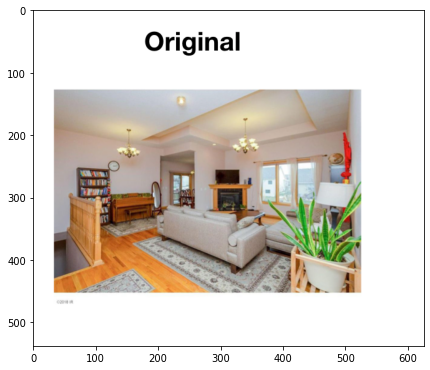

In [184]:
# display the first third
plt.imshow(img_array[:,0:1878//3,:])
plt.show()

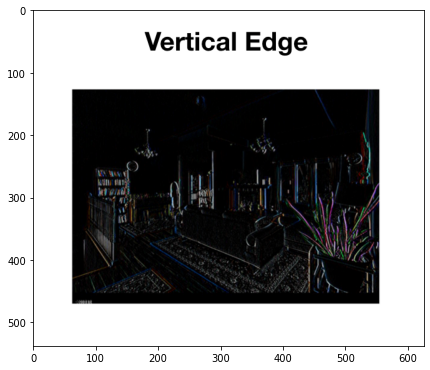

In [185]:
# display the second third
plt.imshow(img_array[:,1878//3:2*1878//3,:])
plt.show()

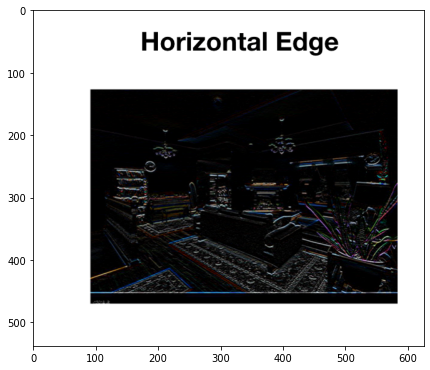

In [186]:
# display the third third
plt.imshow(img_array[:,2*1878//3:,:])
plt.show()

# Part 4. Image segmentation and thresholding 

## 4.1 Definitions
Image segmentation is a group of techniques in digital image processing aiming at analysing and partition an image into multiple parts or regions.

In digital image processing, thresholding is the simplest method of segmenting images. On gray scale images, thresholding is the fact of choosing a pixel value T, and dividing the image in 2 parts :
* the part 1 including the pixels the gray value of which is lower than T
* the part 2 including the pixels the gray value of which is superior or greater than T

Thresholding can be used to separate the foreground and background of an image.

Here, we are using thresholding to create a binary images. The ensemble of 0 and 1 can be used as ***indexes*** for our foreground and background.

In [187]:
mask = example_img.copy()
value_threshold = 90
background = (grayscale_example <= value_threshold)
foreground = (grayscale_example > value_threshold)

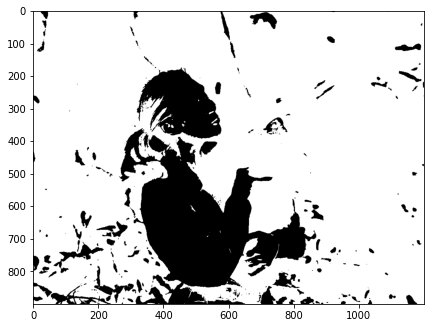

In [188]:
image = Image.fromarray(background)
plt.imshow(image)

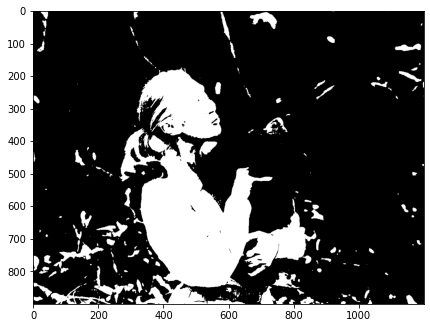

In [189]:
image = Image.fromarray(foreground)
plt.imshow(image)

## 4.2 When is thresholding used?

The main purpose of thresholding is to grasp one part of the image (ex the darker part) and then apply some transformations only on this part (ex : lighting).

Once we have identified a threshold, it becomes possible to preprocess an image in the areas where it needs it most.

This solves a variety of problems such as uneven lighting, hidden features, or even noise present in the background which may affect the model's performance.

Identifying a threshold is an important part of image preprocessing because it allows one to be much more precise.

## 4.3 How can a threshold be identified?

There are many ways to identify a threshold, but the most simple one is by taking the mean.

If we have access to the histogram of the colors, then we are looking for two normal distributions, and will choose a threshold separating them clearly.

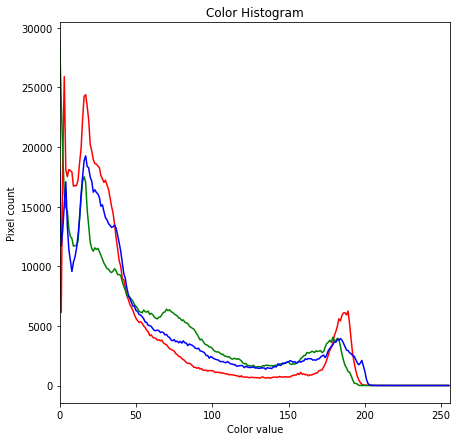

In [190]:
# tuple to select colors of each channel line
colors = ("red", "green", "blue")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.figure()
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        example_img[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.title("Color Histogram")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

plt.show()

This graph shows two distinct places where many values are contained and identifies where to put a threshold. 

## 4.4 Draw the edges based on spacial filtering and thresholding

Here, we use a spacial filter to find the ***edges***, and then, we use two thresholds to link the edges together and find the initial segments of strong edges.

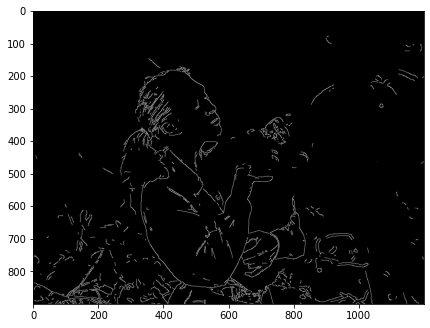

In [191]:
# Thresholds 
#t_lower = 150
#t_upper = 210
t_lower = 100
t_upper = 140

#edge = cv2.Canny(gaussian_blurred_img, t_lower, t_upper)
edge = cv2.Canny(grayscale_example, t_lower, t_upper)

plt.imshow(edge, cmap='gray')
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

***Homeworks*** : Try several combinations of t_upper and t_lower to get the best edge picture. Then, try this combination on another picture (ex : gaussian_blurred_img) and see if you can keep those parameters to get good results.

## 4.5 Background Removal

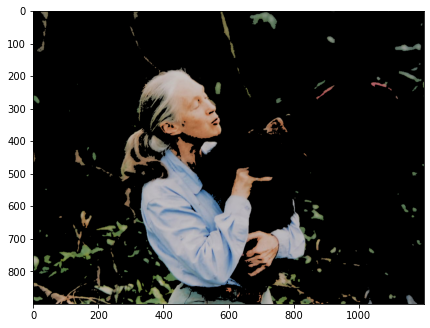

In [192]:
foreground = np.where(foreground[...,None],example_img,0)
background = np.where(background[...,None],example_img,0)
plt.imshow(cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB))
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

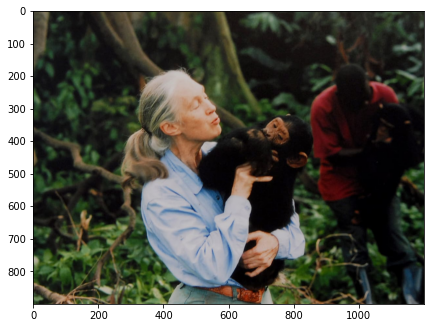

In [193]:
img_added = foreground + background
plt.imshow(cv2.cvtColor(img_added, cv2.COLOR_BGR2RGB))
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

## 4.6 Brightness adjustment

Here, the pixel values are modified linearly. If it were grayscale image, we would have :
$$ P2 = Alpha . P1 + Beta$$
* alpha > 1 increases the contrast
* alpha < 1 decreases the contrast
* beta > 1 makes the picture lighter
* beta < 1 makes the picture darker

In [194]:
alpha = 1.5
beta = 50
background_adjusted = cv2.convertScaleAbs(background, alpha=alpha, beta=beta)

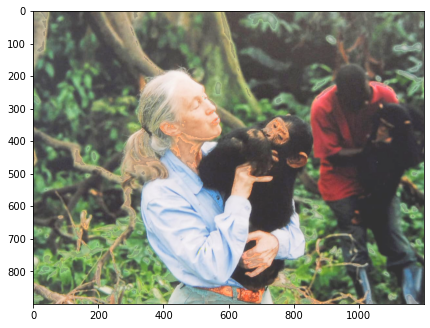

In [195]:
img_adjusted = foreground + background_adjusted
plt.imshow(cv2.cvtColor(img_adjusted, cv2.COLOR_BGR2RGB))
plt.show()

 Thanks to this adjustment, the foreground is not too light, and we have much more details on the chimpanzees.

***Homeworks*** : Why could you propose to get a better result ? As soon as you get an answer, try it by improving or completing the code below.

### 